In [58]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from keras.optimizers      import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24
# the scope of the LSTM Model
stations = 66

# convert an array of values into a dataset matrix, adjusted to make a dateset that is 66 wide
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        # Makes sure that the array isn't the last 2 or 3 or whatever bits. It has to be the full 24
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a.T)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, :].T)
    return np.array(dataX), np.array(dataY)

def predict_with_uncertainty(model, dataset, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (stations,look_forward,) )

    for iter in range(n_iter):
        all_pred[iter] = np.array( f([dataset.reshape( (1,) + dataset.shape), 1]) ).reshape(66, 24)
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

# given a model and data from the original dataset, it uses predict_with_uncertainty to predict with dropout
def run_predictions (model, dataset):

    # scale the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(np.array(dataset))
    data = dataset.T

    # feeds the model and data into a function that will activate the dro-out
    all_pred, avg_pred, std = predict_with_uncertainty(model, data)
    # All the predictions
    for i in range(all_pred.shape[0]):
        for j in range(all_pred.shape[2]):
            all_pred[i,:,j] = scaler.inverse_transform(all_pred[i,:,j].reshape(1,-1))
    for i in range(look_forward):
        # The Average Prediction
        avg_pred[:,i] = scaler.inverse_transform(avg_pred[:,i].reshape(1,-1))
        # The Standard Deviation At Each T Of Prediction
        std[:,i] = scaler.inverse_transform(std[:,i].reshape(1,-1))

    return all_pred, avg_pred, std

In [82]:
def predict (model, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    # creates matrices to hold the 
    avg_preds = np.zeros((288*total_days/delta, look_forward))
    true_vals = np.zeros((288*total_days/delta, look_forward))
    cdf_vals  = np.zeros((288*total_days/delta, look_forward))

    percent_over = np.zeros(288*total_days/delta)
    # Runs all the predictions
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta

        # Gets predictions
        all_pred, avg_pred, std = run_predictions (model, dataset_orig[point-look_back:point])

        # Reshapes all of the things
        true_val = dataset_orig[point:point+look_forward,:].T
        avg_pred = avg_pred
        std = std
        
        #percent_over[i] = 100.0 * (np.ones((len(all_pred),1) )*true_val - all_pred < 0).sum() / all_pred.size

        # converts the original values to cdf values according to the cumullative distibution functions at t+1, t+2, ..., t+24 (0.0-1.0)
        # Adds the values to the overall matrix of cdf
        cdf_vals[i,:] = norm.cdf(true_val, loc=avg_pred, scale=std)

        avg_preds[i], true_vals[i] = avg_pred, true_val

        if(show_graph):
            for i in range (stations):
                plt.subplot(stations, 1, i)
                
                # plots the uncertainty to the degree of half a standard deviation
                plt.fill_between(range(point, point+look_forward), 
                                 avg_pred + std/2.0, 
                                 avg_pred - std/2.0, 
                                 facecolor='red', alpha=0.25)
                # plots the uncertainty to the degree of a full standard deviation
                plt.fill_between(range(point, point+look_forward), 
                                 avg_pred + std, 
                                 avg_pred - std, 
                                 facecolor='red', alpha=0.25)
                # plots the average predictions
                plt.plot(range(point, point+look_forward), avg_pred, color='red', alpha=1)

    print "Percent Overestimating: {}".format(np.mean(percent_over))

    if show_graph:
        for i in range (stations):
            plt.subplot(stations, 1, i)
            plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,i])
            plt.axhline(0)
        plt.show()

    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    return cdf_v


In [4]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
# dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)
dataframe = dataframe.groupby('day_hour').sum()
# removes the timestamp at column 67
dataset_orig = dataframe.values[:,:stations]
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)


In [6]:
# split into train and test sets
train_size = 288 * 10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
print trainX.shape


(2545, 66, 288)


In [10]:
# creates a model but does not compile the model
def create_model(rate = 0.2):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(stations, look_back)))
    lstm = LSTM(256, recurrent_dropout=0.3, return_sequences=True)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(look_forward))
    return model

In [12]:
def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24)**1.3
    w = w / w.sum()
    w = w[:,None]
    W = K.variable(value = w)
    return K.dot( K.abs(y_pred-y_true), W)

batch = 1
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.2)

np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0))

for i in range(1):
    model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)

# cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
# for i in range (24):
#     plt.hist(cdf_matrix[:,i],20)
#     plt.show()

Epoch 1/60
23s - loss: 0.1599
Epoch 2/60
21s - loss: 0.1140
Epoch 3/60
21s - loss: 0.0970
Epoch 4/60
21s - loss: 0.0887
Epoch 5/60
23s - loss: 0.0834
Epoch 6/60
21s - loss: 0.0799
Epoch 7/60
21s - loss: 0.0777
Epoch 8/60
21s - loss: 0.0760
Epoch 9/60
22s - loss: 0.0747
Epoch 10/60
21s - loss: 0.0736
Epoch 11/60
23s - loss: 0.0729
Epoch 12/60
20s - loss: 0.0722
Epoch 13/60
21s - loss: 0.0716
Epoch 14/60
22s - loss: 0.0711
Epoch 15/60
23s - loss: 0.0708
Epoch 16/60
22s - loss: 0.0704
Epoch 17/60
22s - loss: 0.0700
Epoch 18/60
22s - loss: 0.0697
Epoch 19/60
22s - loss: 0.0695
Epoch 20/60
23s - loss: 0.0691
Epoch 21/60
20s - loss: 0.0690
Epoch 22/60
21s - loss: 0.0688
Epoch 23/60
22s - loss: 0.0686
Epoch 24/60
22s - loss: 0.0684
Epoch 25/60
24s - loss: 0.0683
Epoch 26/60
22s - loss: 0.0680
Epoch 27/60
20s - loss: 0.0680
Epoch 28/60
22s - loss: 0.0678
Epoch 29/60
21s - loss: 0.0678
Epoch 30/60
22s - loss: 0.0675
Epoch 31/60
22s - loss: 0.0675
Epoch 32/60
22s - loss: 0.0675
Epoch 33/60
21s -

In [83]:
predict(model, total_days=1,day=11,delta=24)

ValueError: could not broadcast input array from shape (66,24) into shape (24)

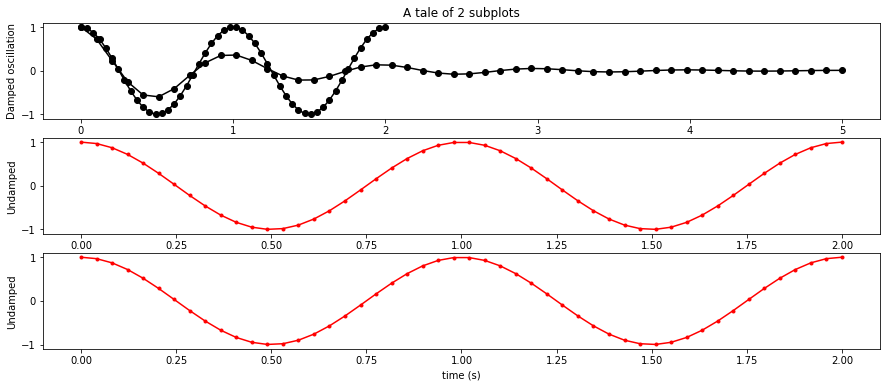

In [79]:

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(3, 1, 1)
plt.plot(x1, y1, 'ko-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')
plt.plot(x2, y2, 'ko-')

plt.subplot(3, 1, 2)
plt.plot(x2, y2, 'r.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.subplot(3, 1, 3)
plt.plot(x2, y2, 'r.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')


plt.show()
